In [1]:
# import os
# os.getcwd()
# os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
def eval_sq(kappa, epsilon, chain, qq, n_sample = 20, n_merge = 4, n_choice = 1e8, rayleigh=False):
    ## generate spectra of three different grids
    S_q_list = []
    S_q_2D_list = []

    chain_Cc_list = []
    for i, grid in enumerate(['SC','RB','RT']):
        S_q_i = np.zeros_like(qq)
        qq_2D = np.concatenate((-np.flip(qq), np.array([0.0]), qq))
        S_q_2D_i = np.zeros([len(qq_2D),len(qq_2D),3])
        for j in trange(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon


            chain.chain_grid()
            N = chain.N
            chain_box = chain.box
            
            chain.scatter_direct_aniso(qq,n_merge=n_merge, n_choice=n_choice)
            S_q_i = S_q_i + chain.S_q
            S_q_2D_i = S_q_2D_i + chain.S_q_2D

        #     E_j = np.sum(chain.E_list)
        #     E_total+=E_j
        # E_total = E_total/n_sample
        # print(E_total)

        qq = chain.qq    
        qq_2D = chain.qq_2D
        S_q_list.append(S_q_i/n_sample) # Append the S(Q) of given grid type
        S_q_2D_list.append(S_q_2D_i/n_sample) # Append the 2D S(Q) of given grid type

    ## Rayleigh chain
    if rayleigh:
        S_q_i = np.zeros_like(qq)
        qq_2D = np.concatenate((-np.flip(qq), np.array([0.0]), qq))
        S_q_2D_i = np.zeros([len(qq_2D),len(qq_2D),3])
        chain.a = kappa
        for j in trange(n_sample):
            chain.chain()
            chain.scatter_direct_aniso(qq,n_merge=n_merge, n_choice=n_choice)
            S_q_i = S_q_i + chain.S_q
            S_q_2D_i = S_q_2D_i + chain.S_q_2D
        S_q_list.append(S_q_i/n_sample) # Append the S(Q) of given grid type
        S_q_2D_list.append(S_q_2D_i/n_sample) # Append the 2D S(Q) of given grid type

    return np.array(S_q_list), np.array(S_q_2D_list)

In [3]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 5000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 0
chain.d_exc = 0.1
chain.f = 0.0

kappa_list = np.array([50])
epsilon_list = [0]

parameters_list = []
S_q_list_param = []
S_q_2D_list_param = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])
        qq = 2*np.pi*(np.linspace(5,100,20))/N_backbone

        # Chain stiffness
        chain.kappa = kappa
        chain.epsilon = epsilon

        S_q_list_grid, S_q_2D_list_grid = eval_sq(kappa, epsilon, chain, qq, 
                                                  n_sample = 64, n_merge = 2, rayleigh=True)
        S_q_list_param.append(S_q_list_grid)
        S_q_2D_list_param.append(S_q_2D_list_grid)
        
        ## save results
        S_q_list_param = np.array(S_q_list_param)
        S_q_2D_list_param = np.array(S_q_2D_list_param)
        mdic = {"S_q_list_param":S_q_list_param, "S_q_2D_list_param":S_q_2D_list_param, "qq":qq, "parameters_list":parameters_list}
        savemat("sq_2D_m2_64_local"+"_{:}_{:}.mat".format(float(kappa),float(epsilon)),mdic)

  0%|          | 0/64 [00:00<?, ?it/s]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  2%|▏         | 1/64 [02:24<2:31:48, 144.59s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  3%|▎         | 2/64 [04:47<2:28:19, 143.54s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  5%|▍         | 3/64 [07:09<2:25:25, 143.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  6%|▋         | 4/64 [09:35<2:23:58, 143.98s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  8%|▊         | 5/64 [12:01<2:22:26, 144.85s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  9%|▉         | 6/64 [14:23<2:18:58, 143.76s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 11%|█         | 7/64 [16:42<2:15:07, 142.23s/it]

2500 beads and 6247486 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 12%|█▎        | 8/64 [18:59<2:11:10, 140.54s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 14%|█▍        | 9/64 [21:18<2:08:31, 140.21s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 16%|█▌        | 10/64 [23:37<2:05:45, 139.74s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 17%|█▋        | 11/64 [25:57<2:03:23, 139.70s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 19%|█▉        | 12/64 [28:16<2:01:02, 139.66s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 20%|██        | 13/64 [30:34<1:58:19, 139.20s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 22%|██▏       | 14/64 [32:52<1:55:40, 138.81s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 23%|██▎       | 15/64 [35:10<1:53:04, 138.46s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 25%|██▌       | 16/64 [37:32<1:51:34, 139.47s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 27%|██▋       | 17/64 [39:50<1:48:56, 139.08s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 28%|██▊       | 18/64 [42:11<1:47:08, 139.74s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 30%|██▉       | 19/64 [44:33<1:45:17, 140.40s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 31%|███▏      | 20/64 [46:56<1:43:28, 141.11s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 33%|███▎      | 21/64 [49:19<1:41:30, 141.64s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 34%|███▍      | 22/64 [51:43<1:39:36, 142.30s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 36%|███▌      | 23/64 [54:00<1:36:18, 140.95s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 38%|███▊      | 24/64 [56:19<1:33:30, 140.27s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 39%|███▉      | 25/64 [58:37<1:30:46, 139.66s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 41%|████      | 26/64 [1:00:56<1:28:17, 139.42s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 42%|████▏     | 27/64 [1:03:34<1:29:23, 144.96s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 44%|████▍     | 28/64 [1:05:52<1:25:42, 142.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 45%|████▌     | 29/64 [1:08:10<1:22:26, 141.34s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 47%|████▋     | 30/64 [1:10:28<1:19:32, 140.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 48%|████▊     | 31/64 [1:12:49<1:17:18, 140.56s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 50%|█████     | 32/64 [1:15:14<1:15:38, 141.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 52%|█████▏    | 33/64 [1:17:39<1:13:49, 142.90s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 53%|█████▎    | 34/64 [1:20:04<1:11:49, 143.64s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 55%|█████▍    | 35/64 [1:22:29<1:09:34, 143.93s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 56%|█████▋    | 36/64 [1:24:54<1:07:21, 144.34s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 58%|█████▊    | 37/64 [1:27:30<1:06:30, 147.80s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 59%|█████▉    | 38/64 [1:29:49<1:02:55, 145.21s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 61%|██████    | 39/64 [1:32:08<59:43, 143.33s/it]  

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 62%|██████▎   | 40/64 [1:34:27<56:48, 142.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 64%|██████▍   | 41/64 [1:36:50<54:34, 142.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 66%|██████▌   | 42/64 [1:39:13<52:13, 142.45s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 67%|██████▋   | 43/64 [1:41:52<51:34, 147.34s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 69%|██████▉   | 44/64 [1:44:31<50:20, 151.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 70%|███████   | 45/64 [1:47:26<50:01, 157.97s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 72%|███████▏  | 46/64 [1:50:16<48:31, 161.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 73%|███████▎  | 47/64 [1:52:50<45:07, 159.27s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 75%|███████▌  | 48/64 [1:55:31<42:38, 159.88s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 77%|███████▋  | 49/64 [1:58:58<43:31, 174.07s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 78%|███████▊  | 50/64 [2:02:32<43:24, 186.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 80%|███████▉  | 51/64 [2:06:05<42:02, 194.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 81%|████████▏ | 52/64 [2:09:42<40:12, 201.07s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 83%|████████▎ | 53/64 [2:13:37<38:43, 211.19s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 84%|████████▍ | 54/64 [2:17:36<36:36, 219.62s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 86%|████████▌ | 55/64 [2:22:09<35:20, 235.61s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 88%|████████▊ | 56/64 [2:27:12<34:06, 255.85s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 89%|████████▉ | 57/64 [2:32:34<32:08, 275.56s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 91%|█████████ | 58/64 [2:36:04<25:34, 255.80s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 92%|█████████▏| 59/64 [2:39:36<20:14, 242.88s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 94%|█████████▍| 60/64 [2:43:07<15:32, 233.22s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 95%|█████████▌| 61/64 [2:47:14<11:52, 237.48s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 97%|█████████▋| 62/64 [2:50:58<07:46, 233.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 98%|█████████▊| 63/64 [2:54:46<03:51, 231.55s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/64 [00:00<?, ?it/s]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  2%|▏         | 1/64 [04:32<4:46:38, 272.99s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  3%|▎         | 2/64 [09:41<5:03:45, 293.96s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  5%|▍         | 3/64 [13:34<4:30:33, 266.12s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  6%|▋         | 4/64 [17:40<4:18:10, 258.17s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  8%|▊         | 5/64 [21:06<3:55:25, 239.42s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  9%|▉         | 6/64 [24:27<3:38:37, 226.16s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 11%|█         | 7/64 [27:56<3:29:35, 220.63s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 12%|█▎        | 8/64 [31:39<3:26:42, 221.47s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 14%|█▍        | 9/64 [35:07<3:19:13, 217.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 16%|█▌        | 10/64 [38:50<3:17:08, 219.06s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 17%|█▋        | 11/64 [42:31<3:13:57, 219.58s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 19%|█▉        | 12/64 [46:13<3:10:58, 220.36s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 20%|██        | 13/64 [49:37<3:03:08, 215.46s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 22%|██▏       | 14/64 [53:12<2:59:11, 215.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 23%|██▎       | 15/64 [56:25<2:50:22, 208.63s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 25%|██▌       | 16/64 [1:00:18<2:52:49, 216.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 27%|██▋       | 17/64 [1:03:58<2:50:00, 217.03s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 28%|██▊       | 18/64 [1:07:25<2:44:01, 213.94s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 30%|██▉       | 19/64 [1:10:04<2:28:16, 197.70s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 31%|███▏      | 20/64 [1:12:38<2:15:13, 184.40s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 33%|███▎      | 21/64 [1:15:07<2:04:35, 173.86s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 34%|███▍      | 22/64 [1:17:34<1:56:05, 165.86s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 36%|███▌      | 23/64 [1:20:05<1:50:15, 161.36s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 38%|███▊      | 24/64 [1:22:35<1:45:12, 157.82s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 39%|███▉      | 25/64 [1:25:04<1:40:51, 155.16s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 41%|████      | 26/64 [1:27:33<1:37:08, 153.39s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 42%|████▏     | 27/64 [1:30:07<1:34:37, 153.43s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 44%|████▍     | 28/64 [1:32:36<1:31:22, 152.29s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 45%|████▌     | 29/64 [1:35:05<1:28:12, 151.23s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 47%|████▋     | 30/64 [1:37:35<1:25:28, 150.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 48%|████▊     | 31/64 [1:40:03<1:22:32, 150.06s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 50%|█████     | 32/64 [1:42:33<1:19:57, 149.91s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 52%|█████▏    | 33/64 [1:45:08<1:18:13, 151.41s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 53%|█████▎    | 34/64 [1:47:37<1:15:21, 150.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 55%|█████▍    | 35/64 [1:50:08<1:12:59, 151.03s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 56%|█████▋    | 36/64 [1:52:19<1:07:35, 144.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 58%|█████▊    | 37/64 [1:54:29<1:03:10, 140.39s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 59%|█████▉    | 38/64 [1:56:40<59:39, 137.66s/it]  

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 61%|██████    | 39/64 [1:58:56<57:10, 137.21s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 62%|██████▎   | 40/64 [2:01:30<56:52, 142.17s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 64%|██████▍   | 41/64 [2:04:05<55:58, 146.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 66%|██████▌   | 42/64 [2:06:42<54:41, 149.17s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 67%|██████▋   | 43/64 [2:09:19<53:04, 151.67s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 69%|██████▉   | 44/64 [2:11:59<51:21, 154.07s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 70%|███████   | 45/64 [2:14:35<48:59, 154.68s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 72%|███████▏  | 46/64 [2:17:18<47:08, 157.12s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 73%|███████▎  | 47/64 [2:19:57<44:43, 157.87s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 75%|███████▌  | 48/64 [2:22:38<42:19, 158.70s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 77%|███████▋  | 49/64 [2:26:16<44:05, 176.36s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 78%|███████▊  | 50/64 [2:28:52<39:44, 170.32s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 80%|███████▉  | 51/64 [2:31:42<36:54, 170.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 81%|████████▏ | 52/64 [2:34:42<34:39, 173.31s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 83%|████████▎ | 53/64 [2:37:26<31:13, 170.34s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 84%|████████▍ | 54/64 [2:40:31<29:06, 174.68s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 86%|████████▌ | 55/64 [2:43:23<26:06, 174.11s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 88%|████████▊ | 56/64 [2:47:21<25:45, 193.15s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 89%|████████▉ | 57/64 [2:50:59<23:25, 200.72s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 91%|█████████ | 58/64 [2:54:57<21:09, 211.66s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 92%|█████████▏| 59/64 [2:58:47<18:06, 217.23s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 94%|█████████▍| 60/64 [3:04:26<16:55, 253.80s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 95%|█████████▌| 61/64 [3:08:17<12:21, 247.07s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 97%|█████████▋| 62/64 [3:11:59<07:58, 239.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 98%|█████████▊| 63/64 [3:16:01<04:00, 240.23s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/64 [00:00<?, ?it/s]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  2%|▏         | 1/64 [04:10<4:23:05, 250.56s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  3%|▎         | 2/64 [07:51<4:00:52, 233.10s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  5%|▍         | 3/64 [12:49<4:27:14, 262.86s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  6%|▋         | 4/64 [17:12<4:23:01, 263.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  8%|▊         | 5/64 [21:39<4:19:44, 264.15s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  9%|▉         | 6/64 [25:48<4:10:36, 259.25s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 11%|█         | 7/64 [30:20<4:10:12, 263.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 12%|█▎        | 8/64 [35:17<4:15:39, 273.92s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 14%|█▍        | 9/64 [39:41<4:08:12, 270.77s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 16%|█▌        | 10/64 [44:09<4:03:04, 270.09s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 17%|█▋        | 11/64 [48:50<4:01:37, 273.54s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 19%|█▉        | 12/64 [52:34<3:43:53, 258.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 20%|██        | 13/64 [55:06<3:12:06, 226.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 22%|██▏       | 14/64 [57:35<2:49:06, 202.93s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 23%|██▎       | 15/64 [1:00:22<2:36:50, 192.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 25%|██▌       | 16/64 [1:03:18<2:29:47, 187.24s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 27%|██▋       | 17/64 [1:06:12<2:23:33, 183.27s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 28%|██▊       | 18/64 [1:09:00<2:17:01, 178.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 30%|██▉       | 19/64 [1:12:55<2:26:37, 195.50s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 31%|███▏      | 20/64 [1:17:19<2:38:26, 216.06s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 33%|███▎      | 21/64 [1:22:08<2:50:35, 238.03s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 34%|███▍      | 22/64 [1:25:47<2:42:33, 232.23s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 36%|███▌      | 23/64 [1:29:30<2:36:44, 229.37s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 38%|███▊      | 24/64 [1:31:54<2:15:59, 204.00s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 39%|███▉      | 25/64 [1:34:18<2:00:52, 185.97s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 41%|████      | 26/64 [1:36:43<1:49:54, 173.55s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 42%|████▏     | 27/64 [1:39:07<1:41:30, 164.62s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 44%|████▍     | 28/64 [1:41:32<1:35:15, 158.77s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 45%|████▌     | 29/64 [1:43:55<1:29:57, 154.22s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 47%|████▋     | 30/64 [1:46:19<1:25:35, 151.05s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 48%|████▊     | 31/64 [1:48:41<1:21:38, 148.45s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 50%|█████     | 32/64 [1:51:07<1:18:44, 147.65s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 52%|█████▏    | 33/64 [1:53:32<1:15:48, 146.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 53%|█████▎    | 34/64 [1:55:54<1:12:37, 145.25s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 55%|█████▍    | 35/64 [1:58:17<1:09:58, 144.77s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 56%|█████▋    | 36/64 [2:00:43<1:07:37, 144.92s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 58%|█████▊    | 37/64 [2:03:04<1:04:43, 143.82s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 59%|█████▉    | 38/64 [2:05:28<1:02:26, 144.08s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 61%|██████    | 39/64 [2:07:53<1:00:03, 144.13s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 62%|██████▎   | 40/64 [2:10:15<57:28, 143.70s/it]  

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 64%|██████▍   | 41/64 [2:12:39<55:04, 143.65s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 66%|██████▌   | 42/64 [2:15:04<52:47, 144.00s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 67%|██████▋   | 43/64 [2:17:28<50:23, 143.99s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 69%|██████▉   | 44/64 [2:19:52<47:59, 143.95s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 70%|███████   | 45/64 [2:22:15<45:33, 143.86s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 72%|███████▏  | 46/64 [2:24:39<43:08, 143.78s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 73%|███████▎  | 47/64 [2:27:03<40:46, 143.91s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 75%|███████▌  | 48/64 [2:29:26<38:17, 143.59s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 77%|███████▋  | 49/64 [2:31:48<35:48, 143.24s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 78%|███████▊  | 50/64 [2:34:11<33:23, 143.11s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 80%|███████▉  | 51/64 [2:36:34<30:59, 143.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 81%|████████▏ | 52/64 [2:38:58<28:39, 143.29s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 83%|████████▎ | 53/64 [2:41:20<26:13, 143.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 84%|████████▍ | 54/64 [2:43:44<23:52, 143.23s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 86%|████████▌ | 55/64 [2:46:07<21:29, 143.24s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 88%|████████▊ | 56/64 [2:48:31<19:07, 143.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 89%|████████▉ | 57/64 [2:50:54<16:42, 143.27s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 91%|█████████ | 58/64 [2:53:18<14:21, 143.55s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 92%|█████████▏| 59/64 [2:55:41<11:57, 143.47s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 94%|█████████▍| 60/64 [2:58:04<09:32, 143.24s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 95%|█████████▌| 61/64 [3:00:28<07:10, 143.51s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 97%|█████████▋| 62/64 [3:02:51<04:46, 143.22s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 98%|█████████▊| 63/64 [3:05:14<02:23, 143.17s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/64 [00:00<?, ?it/s]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  2%|▏         | 1/64 [02:24<2:31:29, 144.28s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  3%|▎         | 2/64 [04:47<2:28:41, 143.89s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  5%|▍         | 3/64 [07:12<2:26:47, 144.39s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  6%|▋         | 4/64 [09:37<2:24:30, 144.51s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  8%|▊         | 5/64 [12:00<2:21:25, 143.82s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


  9%|▉         | 6/64 [14:23<2:18:59, 143.79s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 11%|█         | 7/64 [16:48<2:16:45, 143.96s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 12%|█▎        | 8/64 [19:12<2:14:26, 144.05s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 14%|█▍        | 9/64 [21:37<2:12:27, 144.50s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 16%|█▌        | 10/64 [24:02<2:09:57, 144.39s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 17%|█▋        | 11/64 [26:25<2:07:20, 144.16s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 19%|█▉        | 12/64 [28:48<2:04:39, 143.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 20%|██        | 13/64 [31:11<2:02:04, 143.62s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 22%|██▏       | 14/64 [33:34<1:59:30, 143.41s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 23%|██▎       | 15/64 [35:57<1:56:57, 143.22s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 25%|██▌       | 16/64 [38:21<1:54:40, 143.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 27%|██▋       | 17/64 [40:46<1:52:46, 143.97s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 28%|██▊       | 18/64 [43:09<1:50:11, 143.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 30%|██▉       | 19/64 [45:32<1:47:37, 143.50s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 31%|███▏      | 20/64 [47:55<1:44:57, 143.12s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 33%|███▎      | 21/64 [50:17<1:42:28, 143.00s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 34%|███▍      | 22/64 [52:41<1:40:10, 143.11s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 36%|███▌      | 23/64 [55:03<1:37:35, 142.83s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 38%|███▊      | 24/64 [57:26<1:35:21, 143.04s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 39%|███▉      | 25/64 [59:50<1:33:03, 143.18s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 41%|████      | 26/64 [1:02:12<1:30:32, 142.96s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 42%|████▏     | 27/64 [1:04:34<1:27:56, 142.61s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 44%|████▍     | 28/64 [1:06:57<1:25:35, 142.64s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 45%|████▌     | 29/64 [1:09:20<1:23:22, 142.92s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 47%|████▋     | 30/64 [1:11:46<1:21:29, 143.79s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 48%|████▊     | 31/64 [1:14:13<1:19:38, 144.81s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 50%|█████     | 32/64 [1:16:38<1:17:11, 144.74s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 52%|█████▏    | 33/64 [1:18:59<1:14:14, 143.68s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 53%|█████▎    | 34/64 [1:21:20<1:11:24, 142.81s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 55%|█████▍    | 35/64 [1:23:41<1:08:47, 142.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 56%|█████▋    | 36/64 [1:26:02<1:06:15, 142.00s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 58%|█████▊    | 37/64 [1:28:23<1:03:43, 141.61s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 59%|█████▉    | 38/64 [1:30:46<1:01:30, 141.93s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 61%|██████    | 39/64 [1:33:08<59:11, 142.07s/it]  

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 62%|██████▎   | 40/64 [1:35:32<57:05, 142.73s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 64%|██████▍   | 41/64 [1:37:59<55:10, 143.93s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 66%|██████▌   | 42/64 [1:40:28<53:18, 145.38s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 67%|██████▋   | 43/64 [1:42:54<50:57, 145.61s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 69%|██████▉   | 44/64 [1:45:22<48:48, 146.40s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 70%|███████   | 45/64 [1:47:49<46:23, 146.48s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 72%|███████▏  | 46/64 [1:50:15<43:54, 146.37s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 73%|███████▎  | 47/64 [1:52:42<41:32, 146.62s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 75%|███████▌  | 48/64 [1:55:08<39:01, 146.35s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 77%|███████▋  | 49/64 [1:57:35<36:36, 146.45s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 78%|███████▊  | 50/64 [2:00:01<34:10, 146.45s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 80%|███████▉  | 51/64 [2:02:27<31:42, 146.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 81%|████████▏ | 52/64 [2:04:54<29:18, 146.50s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 83%|████████▎ | 53/64 [2:07:22<26:54, 146.80s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 84%|████████▍ | 54/64 [2:09:48<24:28, 146.80s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 86%|████████▌ | 55/64 [2:12:15<21:59, 146.63s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 88%|████████▊ | 56/64 [2:14:46<19:44, 148.02s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 89%|████████▉ | 57/64 [2:17:15<17:18, 148.33s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 91%|█████████ | 58/64 [2:19:45<14:53, 148.84s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 92%|█████████▏| 59/64 [2:22:10<12:17, 147.59s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 94%|█████████▍| 60/64 [2:24:32<09:44, 146.03s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 95%|█████████▌| 61/64 [2:26:55<07:14, 144.98s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 97%|█████████▋| 62/64 [2:29:17<04:48, 144.28s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


 98%|█████████▊| 63/64 [2:31:41<02:24, 144.07s/it]

2500 beads and 6247500 pairs used to calculate S(q)
23 plane
13 plane
12 plane


100%|██████████| 64/64 [2:34:03<00:00, 144.43s/it]


[50, 0]


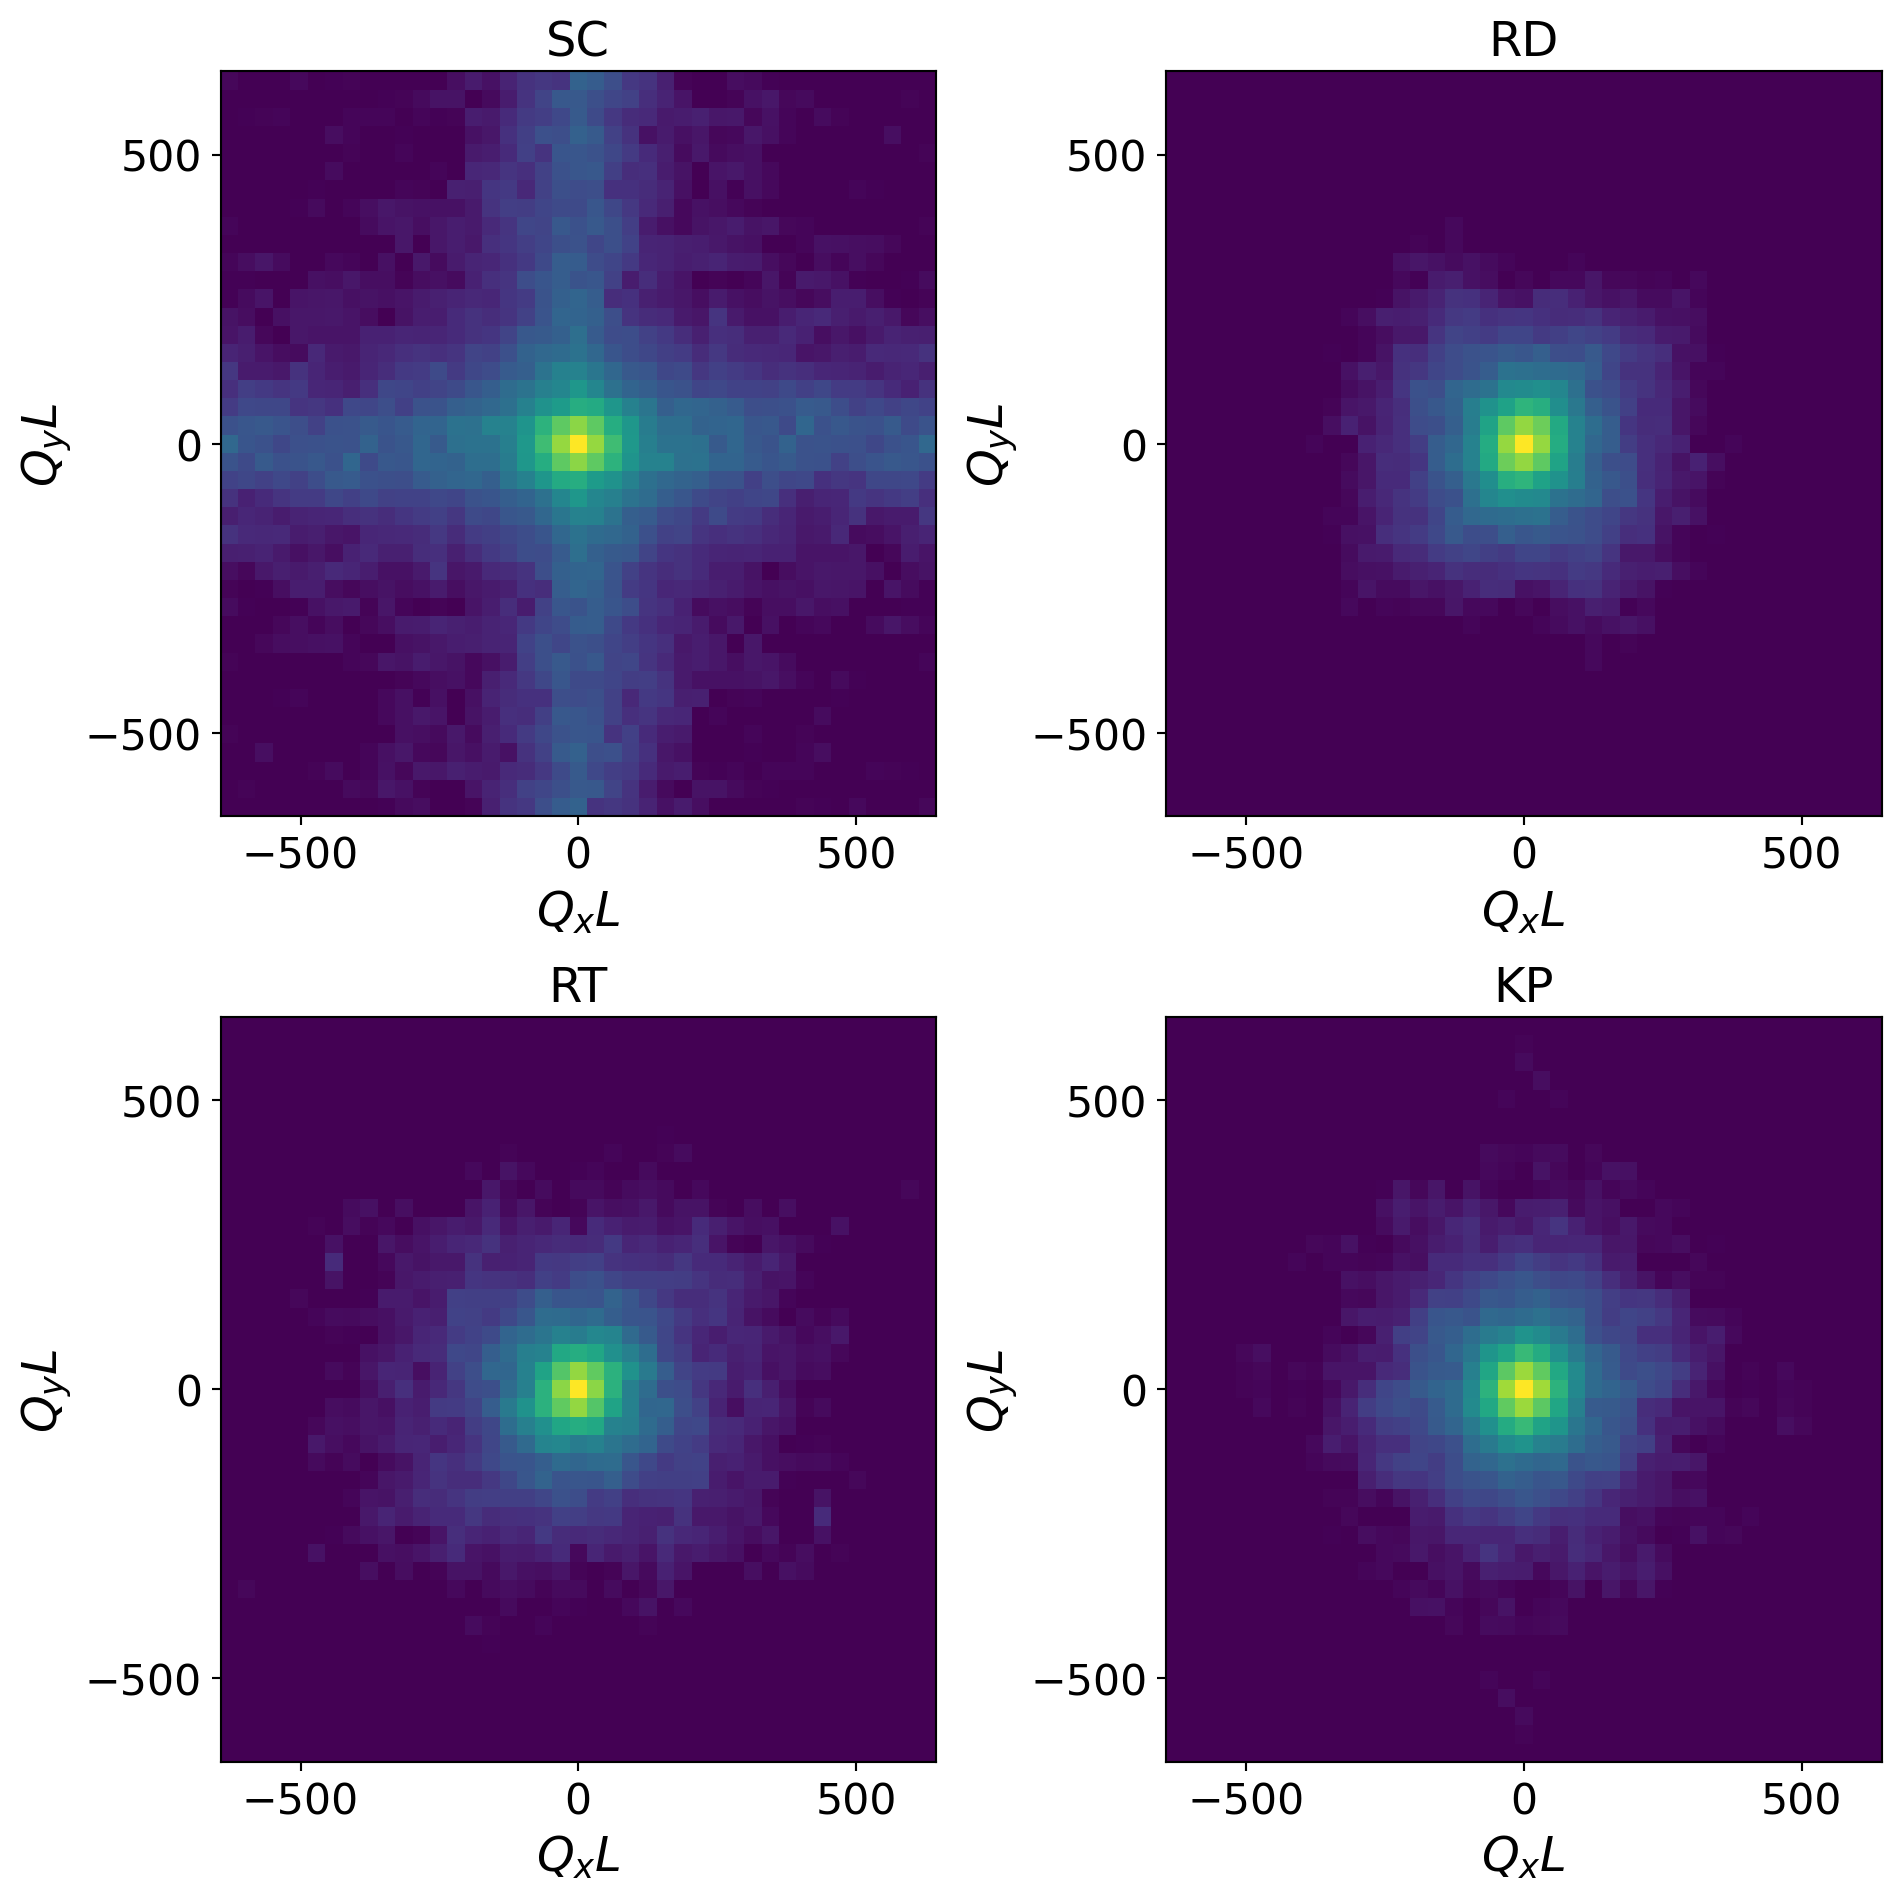

In [11]:
fig = plt.figure(figsize=(10, 10),dpi=192)
for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    S_q_2D_list = S_q_2D_list_param[i]
    qq_2D = np.concatenate((-np.flip(qq), np.array([0.0]), qq))
    qqx, qqy = np.meshgrid(qq_2D,qq_2D)

    for j, grid in enumerate(['SC','RD','RT']):
        ax = fig.add_subplot(2,2,j+1)
        ax.pcolormesh(qqx*N_backbone,qqy*N_backbone,np.log(S_q_2D_list[j,:,:,1]), vmax=0,vmin=-9, shading='auto')
        ax.set_title(grid,fontsize=18)
        ax.set_xlabel(r'$Q_xL$',fontsize=18)
        ax.set_ylabel(r'$Q_yL$',fontsize=18)
        ax.set_xticks([-500,0,500])
        ax.set_yticks([-500,0,500])
        ax.tick_params(axis='both', which='major', labelsize=16)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('KP',fontsize=18)
    ax.pcolormesh(qqx*N_backbone,qqy*N_backbone,np.log(S_q_2D_list[3,:,:,1]), vmax=0,vmin=-9, shading='auto')
    ax.set_xlabel(r'$Q_xL$',fontsize=18)
    ax.set_ylabel(r'$Q_yL$',fontsize=18)
    ax.set_xticks([-500,0,500])
    ax.set_yticks([-500,0,500])
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()

[50, 0]


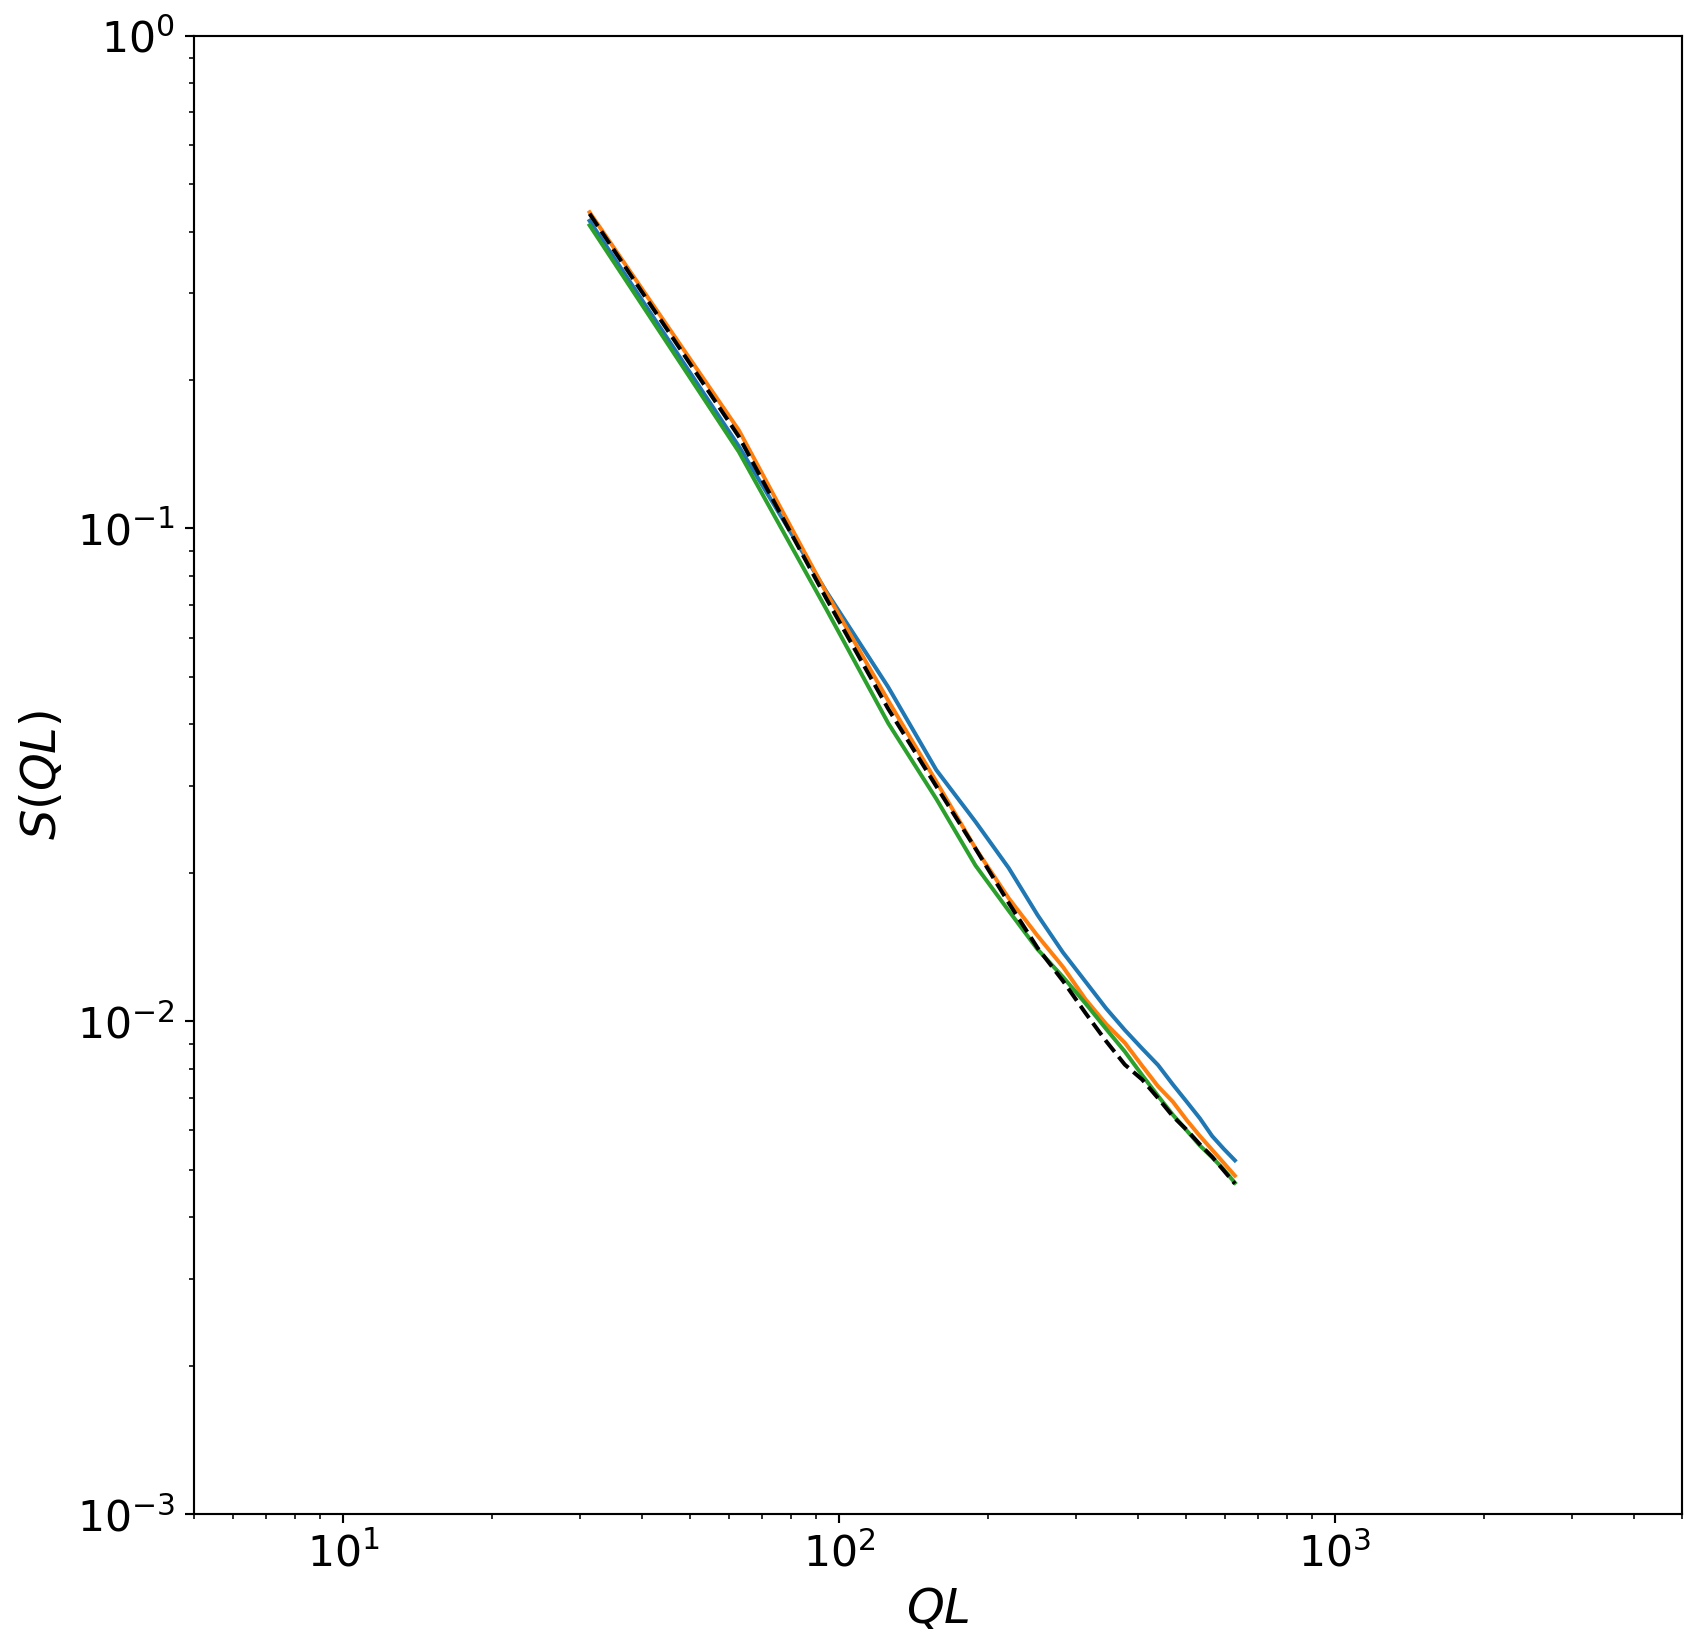

In [5]:
fig = plt.figure(figsize=(10, 10),dpi=192)
for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    S_q_list = S_q_list_param[i]

    ax = fig.add_subplot(1,1,1)
    for j, grid in enumerate(['SC','RD','RT']):
        
        ax.plot(qq*N_backbone, S_q_list[j], label=grid)

    ax.plot(qq*N_backbone, S_q_list[3], '--k', label='KP')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([5,5e3])
    ax.set_ylim([1e-3,1])
    ax.set_xlabel(r'$QL$',fontsize=18)
    ax.set_ylabel(r'$S(QL)$',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)


In [6]:
S_q_list_param[0].shape

(4, 20)

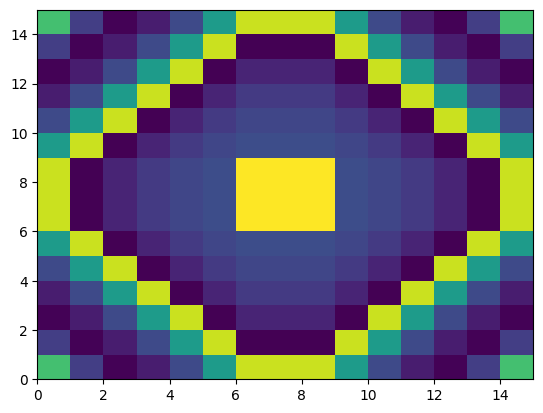

In [7]:
r = np.arange(5)
q = np.arange(7)
q_2D = np.concatenate((np.flip(q), np.array([0.0]), q))

qr_x = np.outer(q_2D,r)
qr_y = np.outer(q,r) # calculate the positive y part

phi_x = np.exp(-1j * qr_x)
phi_y = np.exp(-1j * qr_y)
phi_half = phi_x[:,None] * phi_y[None,:]
phi = np.concatenate((-np.flip(phi_half,axis=1), phi_x[:,None,:], phi_half),axis=1)
S_q_2D = np.abs(np.mean(phi,axis=2))
plt.pcolormesh(S_q_2D)

In [8]:
phi.shape

(15, 15, 5)